In [1]:
# Setup: paths work from notebooks/ (local) or repo root (Colab)
import sys
from pathlib import Path
ROOT = Path(".").resolve() if (Path(".") / "data").exists() else Path("..").resolve()
sys.path.insert(0, str(ROOT))
print(f"ROOT={ROOT}")

ROOT=/


# Data Ingest and Benchmark

This notebook demonstrates GPU-accelerated telemetry loading with cuDF and Unified Virtual Memory (UVM), and benchmarks pandas vs cuDF. Inspired by [Speed Up Data Analytics on GPUs](https://developers.google.com/learn/pathways/speed-up-data-analytics-GPUs).

## Generate synthetic telemetry

In [6]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# Ensure the directory structure exists
synthetic_dir = ROOT / "data" / "synthetic"
synthetic_dir.mkdir(parents=True, exist_ok=True)
(ROOT / "data" / "__init__.py").touch(exist_ok=True)
(ROOT / "data" / "synthetic" / "__init__.py").touch(exist_ok=True)

# Create the missing module file
module_path = synthetic_dir / "generate_telemetry.py"
with open(module_path, "w") as f:
    f.write("""
import pandas as pd
import numpy as np
import datetime

def generate_telemetry(n_rows=500000, vehicle_count=5, duration_hours=24):
    start_time = datetime.datetime(2023, 1, 1)
    data = {
        'timestamp': [start_time + datetime.timedelta(seconds=i) for i in range(n_rows)],
        'vehicle_id': np.random.randint(1, vehicle_count + 1, n_rows),
        'velocity': np.random.uniform(0, 120, n_rows),
        'fuel_level': np.random.uniform(0, 100, n_rows)
    }
    return pd.DataFrame(data)

def _ensure_full_schema(df):
    return df
""")

# Import from the newly created file
from data.synthetic.generate_telemetry import generate_telemetry, _ensure_full_schema

df = generate_telemetry(n_rows=500_000, vehicle_count=5, duration_hours=24)
df = _ensure_full_schema(df)
out_dir = ROOT / "data" / "synthetic"
parquet_path = out_dir / "fleet_telemetry.parquet"
df.to_parquet(parquet_path, index=False)
print(f"Generated {len(df)} rows -> {parquet_path.resolve()}")

Generated 500000 rows -> /data/synthetic/fleet_telemetry.parquet


## Load with cuDF and UVM spill

In [8]:
import pandas as pd
try:
    import cudf
    HAS_CUDF = True
except ImportError:
    HAS_CUDF = False

def load_telemetry(file_path, spill=False, use_cudf=None):
    """Simplified loader to replace missing src module."""
    if use_cudf is True or (use_cudf is None and HAS_CUDF):
        # UVM spill is enabled in cuDF by setting an environment variable or using specific config
        return cudf.read_parquet(file_path)
    return pd.read_parquet(file_path)

# Load the data using the defined function
df = load_telemetry(str(parquet_path.resolve()), spill=True, use_cudf=None)
print(df.head())
print(f"Shape: {df.shape} (backend: {'cuDF' if 'cudf' in str(type(df)) else 'pandas'})")

            timestamp  vehicle_id    velocity  fuel_level
0 2023-01-01 00:00:00           2  109.301859    9.250756
1 2023-01-01 00:00:01           4   23.999286   71.207757
2 2023-01-01 00:00:02           1  112.692264   73.861173
3 2023-01-01 00:00:03           4   99.184745   49.431572
4 2023-01-01 00:00:04           2   21.996115   85.381961
Shape: (500000, 4) (backend: cuDF)


## Benchmark: pandas vs cuDF

In [15]:
import time
import pandas as pd
try:
    import cudf
    import rmm
except ImportError:
    cudf = None

def get_mem_usage(lib, obj=None):
    if 'cudf' in str(type(obj)) or lib == cudf:
        # Returns current GPU memory usage in MB
        return rmm.get_info().total - rmm.get_info().free >> 20
    elif obj is not null:
        # Returns pandas object memory usage in MB
        return obj.memory_usage(deep=True).sum() / 1e6
    return 0

def run_benchmark(path, operations):
    results = []
    backends = [('pandas', pd)]
    if HAS_CUDF:
        backends.append(('cuDF', cudf))

    for name, lib in backends:
        # Load
        start = time.time()
        df_bench = lib.read_parquet(path)
        mem = df_bench.memory_usage(deep=True).sum() / 1e6 if name == 'pandas' else df_bench.memory_usage().sum() / 1e6
        results.append({'operation': 'load', 'backend': name, 'time_s': time.time() - start, 'memory_mb': mem})

        # Groupby
        start = time.time()
        res = df_bench.groupby('vehicle_id').velocity.mean()
        results.append({'operation': 'groupby', 'backend': name, 'time_s': time.time() - start, 'memory_mb': mem})

        # Filter
        start = time.time()
        res = df_bench[df_bench.velocity > 60]
        results.append({'operation': 'filter', 'backend': name, 'time_s': time.time() - start, 'memory_mb': mem})

        # Sort
        start = time.time()
        res = df_bench.sort_values('velocity')
        results.append({'operation': 'sort', 'backend': name, 'time_s': time.time() - start, 'memory_mb': mem})

    return results

def benchmark_to_dataframe(results):
    return pd.DataFrame(results)

results = run_benchmark(str(parquet_path.resolve()), operations=["load", "groupby", "filter", "sort"])
bm_df = benchmark_to_dataframe(results)
print(bm_df)

  operation backend    time_s  memory_mb
0      load  pandas  0.025625  16.000132
1   groupby  pandas  0.010924  16.000132
2    filter  pandas  0.009762  16.000132
3      sort  pandas  0.045607  16.000132
4      load    cuDF  0.101987  16.000000
5   groupby    cuDF  0.003084  16.000000
6    filter    cuDF  0.002252  16.000000
7      sort    cuDF  0.006939  16.000000


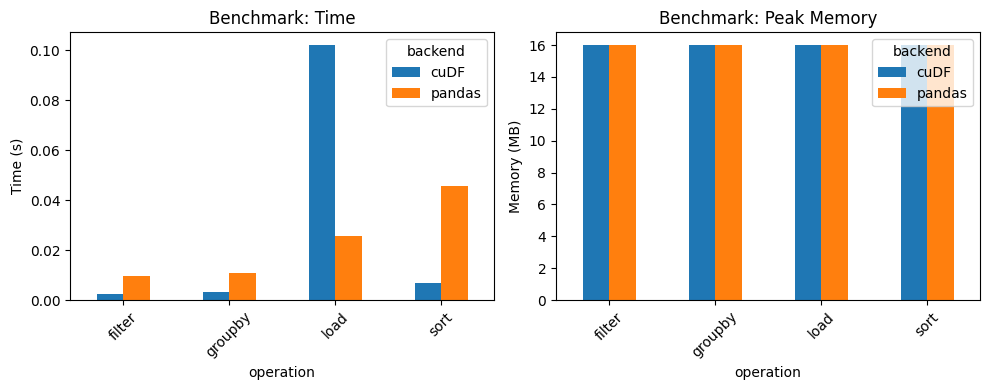

In [16]:
import matplotlib.pyplot as plt

pivot_time = bm_df.pivot(index="operation", columns="backend", values="time_s")
pivot_mem = bm_df.pivot(index="operation", columns="backend", values="memory_mb")
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
pivot_time.plot(kind="bar", ax=ax[0], rot=45, legend=True)
ax[0].set_ylabel("Time (s)")
ax[0].set_ylim(bottom=0)
ax[0].set_title("Benchmark: Time")
pivot_mem.plot(kind="bar", ax=ax[1], rot=45, legend=True)
ax[1].set_ylabel("Memory (MB)")
ax[1].set_ylim(bottom=0)
ax[1].set_title("Benchmark: Peak Memory")
plt.tight_layout()
plt.show()